
# Intermidiate Tutorial

In this tutorial you will learn how to define the non-analytical constants for the Data types presented in the [previous tutorial](./basic.ipynb).

## Polar insulators

The phonon band structure of bulk polar insulators, which we define to be insulators with different atomic species (e.g. AlAs, BaTiO{sub}`3`),
needs extra quantities to be interpolated correctly around the gamma point. These quantities are the so called __non-analytical constants__. They are composed by two tensors:

1. __Dielectric tensor__: this is the high-frequency dielectric tensor of the material, $\epsilon^{\infty}_{ij}$.
2. __Born effective charges tensor__: these are effective charges of the nuclei, usually expressed in unit of charge $e$, $Z^{*}_{I,ij}$

The indices $i$ and $j$ refer to the three Cartesian axes, while $I$ is the atomic index.

```{important}
The tensors $Z^{*}_{I,ij}$ are not symmetric with the exchange of $i$ and $j$!
```

```{admonition} Convention
:class: important 
In `Phonopy` and `aiida-phonopy`, the convention for $Z^{*}_{I,ij}$ indices is as follow:

1. Atomic index.
2. Polarization index.
3. Atomic displacement index.
```

Let's show this with _AlAs_. On the same lines of the [basic tutorial](./basic.ipynb), we define 
{py:class}`~aiida_phonopy.data.preprocess.PreProcessData`:

In [20]:
# ================= IMPORTS ======================== #
from local_module import load_temp_profile
from aiida.plugins import DataFactory, CalculationFactory
from aiida.orm import load_code, Dict

load_temp_profile(
    name="intermidiate-tutorial",
    add_computer=True,
    add_phonopy_code=True,
)

StructureData = DataFactory("core.structure")
PreProcessData = DataFactory("phonopy.preprocess")
PhonopyData = DataFactory("phonopy.phonopy")
PhonopyCalculation = CalculationFactory("phonopy.phonopy")
# ============== STRUCTURE DATA ==================== #
a = 2.839
cell = [[0,a,a],[a,0,a],[a,a,0]]
structure = StructureData(cell=cell)
structure.append_atom(position=(0,0,0), symbols="Al")
structure.append_atom(position=(0.5*a,0.5*a,0.5*a), symbols="As")
# ============= PREPROCESS DATA ==================== #
supercell_matrix = [[-1,1,1],[1,-1,1],[1,1,-1]] # standard cell 8 atoms
preprocess_data =  PreProcessData(structure=structure, supercell_matrix=supercell_matrix)

We could go through and compute the forces for the displaced structure. The result would be:

In [21]:
dict_of_forces = {
    "forces_1": 
    [
        [-0.0988347466,    0.0000000000,    0.0000000000],
        [-0.0200237511,    0.0000000000,    0.0000000000],
        [ 0.0135502277,    0.0000000000,    0.0000000000],
        [ 0.0135502277,    0.0000000000,    0.0000000000],
        [ 0.0230530248,    0.0183687320,    0.0183687320],
        [ 0.0230530248,   -0.0183687320,   -0.0183687320],
        [ 0.0228262535,    0.0179280450,   -0.0179280450],
        [ 0.0228262535,   -0.0179280450,    0.0179280450],
    ],
    "forces_2": 
    [
        [ 0.0228136551,    0.0179285592,    0.0179285592],
        [ 0.0228136551,   -0.0179285592,   -0.0179285592],
        [ 0.0230645948,   -0.0183682178,    0.0183682178],
        [ 0.0230645948,    0.0183682178,   -0.0183682178],
        [-0.1025024252,    0.0000000000,    0.0000000000],
        [-0.0044662632,    0.0000000000,    0.0000000000],
        [ 0.0076060944,    0.0000000000,    0.0000000000],
        [ 0.0076060944,    0.0000000000,    0.0000000000],
    ]
}

phonopy_data =  PhonopyData(preprocess_data=preprocess_data)
phonopy_data.set_forces(dict_of_forces=dict_of_forces)

We may want to try to compute the band structure of the phonons directly.

In [22]:
builder = PhonopyCalculation.get_builder()
builder.code = load_code("phonopy@localhost") # WARNING! You may redefine this
builder.phonopy_data = phonopy_data
builder.parameters = Dict({"band":"auto"})

Submit the calculation.

In [23]:
from aiida.engine import run_get_node

results, node = run_get_node(builder)
print("These are the final results:")
results

These are the final results:


{'output_parameters': <Dict: uuid: 1101d6f1-597d-4441-b84b-14e20402ac3b (pk: 38)>,
 'phonon_bands': <BandsData: uuid: 287620e6-37e6-4904-ae5e-ede6c54d89f3 (pk: 39)>,
 'remote_folder': <RemoteData: uuid: b44b4abf-d761-448a-bdfc-0147e20ea85e (pk: 36)>,
 'retrieved': <FolderData: uuid: 092aa11d-1537-4d04-9f9f-da84d880e2d3 (pk: 37)>}

Check the phonon dispersion.

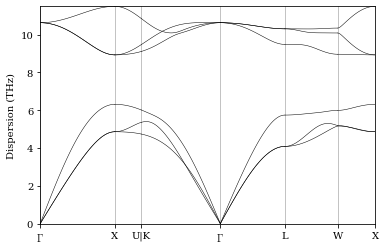

In [24]:
node.outputs.phonon_bands.show_mpl()

It looks fine, isn't it?

Actually, there is a subtle discrepancy. If one would compare this with experiments, a phonon mode seems to miss at $\Gamma$! 
Try to answer the following question before continuing the tutorial.

```{admonition} Question: Can you explain why? 
:class: tip dropdown

The interpolation is missing the _long-range_ contributions. An analytical model can be devised to account for these interactions, often called **dipole-dipole** approximation. This accounts for up to the dipole expansion, meaning accounting for the dielectric and Born effective charges (the dipoles) tensors. Higher order contribution can be added, such as quadrupoles and octupoles (see e.g. [Royo et al., Phys. Rev. Lett., **125** (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.217602)).
```

Let's now add the non-analytical contribution (NAC). Imagine we have already computed such quantities.

:::{admonition} NAC calculation
:class: tip dropdown

The calculation of these quantities can be done in different ways. Usually DFPT implementations are used, or alternatively finite differences upon small electric fields.
:::

In [25]:
phonopy_data_nac = phonopy_data.clone() # the `phonopy_data` is now immutable in AiiDA!

born_charges = [
    [
        [+2.1576, 0, 0], 
        [0, +2.1576, 0], 
        [0, 0, +2.1576]
    ],
    [
        [-2.1576, 0, 0],
        [0, -2.1576, 0],
        [0, 0, -2.1576]
    ],
]

dielectric = [
    [9.4626, 0, 0],
    [0, 9.4626, 0],
    [0, 0, 9.4626],
]

phonopy_data_nac.set_born_charges(born_charges)
phonopy_data_nac.set_dielectric(dielectric)

Does it have the NAC now? Let's ask!

In [26]:
phonopy_data_nac.has_nac_parameters()

True

Hurray!

Now we can recompute the band structure and see if something changes.

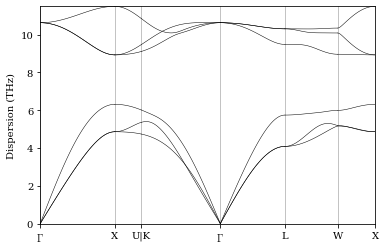

In [27]:
builder.phonopy_data = phonopy_data_nac

results, node = run_get_node(builder)
node.outputs.phonon_bands.show_mpl()

A huge splitting at $\Gamma$ appeared! This is often referred to as __LO-TO splitting__. 

If you want to learn more features, continue with the [next tutorial](./advanced.ipynb).